统计每趟路线上的OD站点

In [1]:
#运行这个代码可以让Python不显示warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import math
import os

In [2]:
##上行线和下行线需要分开处理

In [3]:
xianlu=1028
##先形成第一辆车的上行数据
for checi in range(3,4): 
#for checi in range(1,2):   
    checi=checi
    dir_count = 0
    file_count = 0
    for root, dirs, filenames in os.walk(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)):
        for dir in dirs:
            dir_count += 1
        for file in filenames:
            file_count += 1
    #print ('dir_count ', dir_count)
    #print ('file_count ', file_count)
    if file_count>4:  
        folder = r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'
        files = os.listdir(folder)
        #print(files)
        def file_filter(f):
            #if f[-4:] in ['.png', '.bmp']:查找多个格式
            if f[-8:] in ['line.csv']:
                return True
            else:
                return False
        files = list(filter(file_filter, files))###尽量自己使用的时候不要直接把空列表命名为list,不然list会调用出错
        #print(files)
        
       ######！！！！！第一趟如果是上行发车，那么以下就是(1,2)，否则是（2,3），下一格也要调整
        for tangci in range(4,5): 
        #for tangci in range(3,4): 
            tangci=tangci
            data=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'流量'+str(tangci)+'.xlsx')
            ##按照站点进行集计
            sumdata=pd.DataFrame()
              #!!某辆车下所有车次的数量
            data2 = data.drop_duplicates(subset=['出发站编号','到达站编号'],keep='first')
            #print(data2)
            data2['站点到达人数']=0
            data2['站点出发人数']=0
            sum=0
            for i in range(0,len(data2)):
                p=0
                pm=0
                for j in range(0,len(data)):
                    if data['出发站编号'].iloc[j]==data2['出发站编号'].iloc[i]:
                        p1=data['到达人数'].iloc[j]
                        p2=data['出发人数'].iloc[j]
                        p=p+p1
                        pm=pm+p2
                data2['站点到达人数'].iloc[i]=p
                data2['站点出发人数'].iloc[i]=pm
                sum=sum+pm 
            data3=data2.loc[:,['出发站编号','到达站编号','出发站','到达站','出发站车辆到站时间','到达站车辆到站时间','站点到达人数','站点出发人数']]
            data3.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点流量'+str(tangci)+'.xlsx',index=None)
            data3=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点流量'+str(tangci)+'.xlsx')
            #print(data3)##索引再次不完整
            #sumdata = sumdata.append(data, ignore_index = True)
            print(sum)
            ##按照到站时间，区别站点到站顺序
            data3.sort_values(by=['出发站车辆到站时间','到达站车辆到站时间'],inplace=True)
            data4=data3.loc[:,['出发站编号','到达站编号','出发站','到达站','出发站车辆到站时间','到达站车辆到站时间','站点出发人数']]
            TIME=pd.read_csv(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'TIME.csv')
            #导入站点数据,先全部匹配再flag筛选，不然匹配结果会出None,原因不明
            stop=pd.read_excel(r'F:\data\扬州公交\上下行站点\\'+str(xianlu)+'.xlsx')
            p1 = pyproj.Proj(init="epsg:4326")#wgs坐标系统的EPSG Code,
            p2 = pyproj.Proj(init="epsg:32651")#UTM 51N坐标系统的EPSG Code\n",
           # print(stop)
            lonprj1, latprj1 = pyproj.transform(p1, p2,stop['LONGITUDE'], stop['LATITUDE'])
            stop['lons']=pd.DataFrame(lonprj1)
            stop['lats']=pd.DataFrame(latprj1)
            flag=TIME['上1下0'].iloc[tangci-1]
            if flag==1:
                stop=stop[(stop['站点属性']==flag)|(stop['站点属性']==3)]
                line = pd.read_csv(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+str(tangci)+'_line.csv',encoding='utf-8')
                line=line[(line['LONGITUDE']!=0)&(line['LONGITUDE']!=None)]
                #lonprj, latprj = pyproj.transform(p1, p2,line['LONGITUDE'], line['LATITUDE'])
                #line['lons']=pd.DataFrame(lonprj)
                #line['lats']=pd.DataFrame(latprj)
                #print(stop)
                #print(line)
                import math
                ###将所有站点匹配到最近的轨迹点上
                match=[]
                nearestd=[]
                stop.reset_index(drop=True,inplace=True) 
                line.reset_index(drop=True,inplace=True) 
                for k in range(0,len(stop)):###range写法要求索引连续完整
                    distance=[]
                    x2 = stop['lons'].iloc[k]
                    y2 = stop['lats'].iloc[k]
                    for i in range(0,len(line)):        
                        x1 = line['lons'].iloc[i]
                        y1 = line['lats'].iloc[i]
                        #print(math.sqrt((x2-x1)**2+(y2-y1)**2))
                        distance.append(math.sqrt((x2-x1)**2+(y2-y1)**2))
                        #print(distance)
                        #print(len(distance))
                    # 求列表最小值及索引
                    min_value = min(distance) # 求列表最小值
                    #print(min_value)
                    min_idx = distance.index(min_value) # 求最小值对应索引
                    nearestd.append(min_value)
                    match.append(min_idx)
                    #print('match')
                    #print(match)
                ###最近轨迹点整理
                stop['最近轨迹点索引']=match
                stop['最近点距离']=nearestd
                stop['RECDATETIME']=0
                for k in range(0,len(stop)):
                    sy=stop['最近轨迹点索引'].iloc[k]
                    stop['RECDATETIME'].loc[k]=line['RECDATETIME'].iloc[sy]
                print('站点最近轨迹点匹配完毕')
                #转换时间格式，以便下一步计算
                #在这之前需要排个序,##以空格划分日期和时间
                #标准时间的换算，相对00：00：00过了多少秒
                stop['time_st'] = stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[0]).astype('int')*3600+\
                stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[1]).astype('int')*60+\
                stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[2]).astype('int')
                stop.sort_values(by='time_st',inplace=True)
                stop2=stop.loc[:,['STATIONNO','STATIONNAME','time_st','LONGITUDE','LATITUDE']]
                #stop2.reset_index(drop=True,inplace=True) 
                stop2.reset_index(drop=True,inplace=True) 
                duanmian=stop2
                duanmian['前站编号']=None
                duanmian['前站名称']=None
                duanmian['前站到站时间']=None
                duanmian['后站编号']=None
                duanmian['后站名称']=None
                duanmian['后站到站时间']=None
                duanmian['前站经度']=None
                duanmian['前站纬度']=None
                duanmian['后站经度']=None
                duanmian['后站纬度']=None
                for i in  range(0,len(stop2)-1):
                    k=i+1
                    duanmian['前站编号'].iloc[i]=stop2['STATIONNO'].iloc[i]
                    duanmian['后站编号'].iloc[i]=stop2['STATIONNO'].iloc[k]
                    #list2.append(stop2.loc[[k],['STATIONNO']])
                    duanmian['前站名称'].iloc[i]=stop2['STATIONNAME'].iloc[i]
                    duanmian['后站名称'].iloc[i]=stop2['STATIONNAME'].iloc[k]
                    #list4.append(stop2.loc[[k],['STATIONNAME']])
                    duanmian['前站到站时间'].iloc[i]=stop2['time_st'].iloc[i]
                    duanmian['后站到站时间'].iloc[i]=stop2['time_st'].iloc[k]
                    duanmian['前站经度'].iloc[i]=stop2['LONGITUDE'].iloc[i]
                    duanmian['后站经度'].iloc[i]=stop2['LONGITUDE'].iloc[k]
                    duanmian['前站纬度'].iloc[i]=stop2['LATITUDE'].iloc[i]
                    duanmian['后站纬度'].iloc[i]=stop2['LATITUDE'].iloc[k]
                    #list6.append(stop2.loc[[k],['time_st']])
                duan=duanmian.loc[:,['前站编号','前站名称','前站到站时间','前站经度','前站纬度','后站编号','后站名称','后站到站时间','后站经度','后站纬度']]
                duan=duan.loc[0:len(duan)-2]
                data4.reset_index(drop=True,inplace=True) 
                data4['到达站车辆到站时间'] = data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[2]).astype('int')
                data4['出发站车辆到站时间'] = data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[2]).astype('int')
                data4['站间OD']=0
                data5 = data4.drop_duplicates(subset=['出发站编号'],keep='first')
                #print('data5')
                #print(data5)
                r=data5.index
                for j in r:
                    d=0
                    listx=[]
                    for i in range(0,len(data4)):
                        if data4['出发站编号'].loc[i]==data5['出发站编号'].loc[j]:
                            d=d+1
                            listx.append(i)
                            #print(d)
                        if d!=0:
                            arrive=int(data5['站点出发人数'].loc[j])/d
                            for k in listx:
                               # data4['站间OD'].iloc[k]=math.ceil(arrive)#向上取整
                                data4['站间OD'].iloc[k]=arrive#向上取整
                                 
                #print('data4')  
                #print(data4)
                data4.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点OD'+str(tangci)+'.xlsx',index=None)
                duan['断面客流量']=0
                duan['前站出发人数']=0
                for i in range(0,len(duan)):
                    s_time=duan['前站到站时间'].iloc[i]
                    e_time=duan['后站到站时间'].iloc[i]
                    p=0
                    for j in range(0,len(data4)):
                        if int(data4['出发站车辆到站时间'].iloc[j])<=s_time:
                            #print('出发站车辆到站时间')
                            #print(data4['出发站车辆到站时间'].iloc[j])
                            #print('s_time')
                            #print(s_time)
                            if int(data4['到达站车辆到站时间'].iloc[j])>=e_time:
                                p=p+int(data4['站间OD'].iloc[j])         
                    duan['断面客流量'].iloc[i]=p
                for i in range(0,len(duan)):
                    s_time=duan['前站到站时间'].iloc[i]
                    e_time=duan['后站到站时间'].iloc[i]
                    for j in range(0,len(data4)):
                        if duan['前站编号'].loc[i]==data4['出发站编号'].loc[j]:
                            duan['前站出发人数'].iloc[i]=int(data4['站点出发人数'].iloc[j])         
                #duan.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'段间载客量'+str(tangci)+'.xlsx',index=None)
                #duan=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'段间载客量'+str(tangci)+'.xlsx')

sumod=data4
print(sumod)
sumduan=duan
sumduan

57
站点最近轨迹点匹配完毕
     出发站编号   到达站编号         出发站         到达站  出发站车辆到站时间  到达站车辆到站时间  站点出发人数  \
0   126374  104893     蜀冈公交首末站   山河园（柳馨花园）      71649      72291       1   
1   106372  111264   司徒庙路真州北路东       文汇苑C区      71755      73654       1   
2   102144  100344    龚庄（扬州棋院）      望月路百祥路      71977      72800       4   
3   102144  109034    龚庄（扬州棋院）         月亮园      71977      72845       4   
4   102144  104194    龚庄（扬州棋院）       京华城南门      71977      73070       4   
5   102144  111264    龚庄（扬州棋院）       文汇苑C区      71977      73654       4   
6   101673  100344  中星海上紫郡（冯庄）      望月路百祥路      72181      72800       1   
7   104893  104214   山河园（柳馨花园）     京华城·怡景苑      72291      73005       4   
8   104893  109704   山河园（柳馨花园）   文汇西路真州中路东      72291      73362       4   
9   104893  114704   山河园（柳馨花园）       橡树湾南门      72291      73507       4   
10  108903  101073         雍华府  大刘庄（和美第东门）      72559      73196       7   
11  108903  114853         雍华府      绿杨新苑东门      72559      73252       7 

,前站编号,前站名称,前站到站时间,前站经度,前站纬度,后站编号,后站名称,后站到站时间,后站经度,后站纬度,断面客流量,前站出发人数
0,126374,蜀冈公交首末站,71649,119.365616,32.429459,106372,司徒庙路真州北路东,71755,119.370416,32.428634,1,1
1,106372,司徒庙路真州北路东,71755,119.370416,32.428634,125552,维扬中学北门,71800,119.373614,32.428208,2,1
2,125552,维扬中学北门,71800,119.373614,32.428208,104292,汇锦花苑北门,71896,119.380387,32.427079,2,0
3,104292,汇锦花苑北门,71896,119.380387,32.427079,102144,龚庄（扬州棋院）,71977,119.386374,32.426366,2,0
4,102144,龚庄（扬州棋院）,71977,119.386374,32.426366,107573,西湖镇政府,72012,119.388873,32.425888,6,4
5,107573,西湖镇政府,72012,119.388873,32.425888,100523,润辉广场（碧水栖庭）,72079,119.389558,32.423141,6,0
6,100523,润辉广场（碧水栖庭）,72079,119.389558,32.423141,101673,中星海上紫郡（冯庄）,72181,119.390348,32.417123,6,0
7,101673,中星海上紫郡（冯庄）,72181,119.390348,32.417123,104893,山河园（柳馨花园）,72291,119.389028,32.408256,7,1
8,104893,山河园（柳馨花园）,72291,119.389028,32.408256,102453,福康园护理院（海德庄园）,72443,119.389699,32.403023,9,4
9,102453,福康园护理院（海德庄园）,72443,119.389699,32.403023,108903,雍华府,72559,119.390578,32.396268,9,0


28


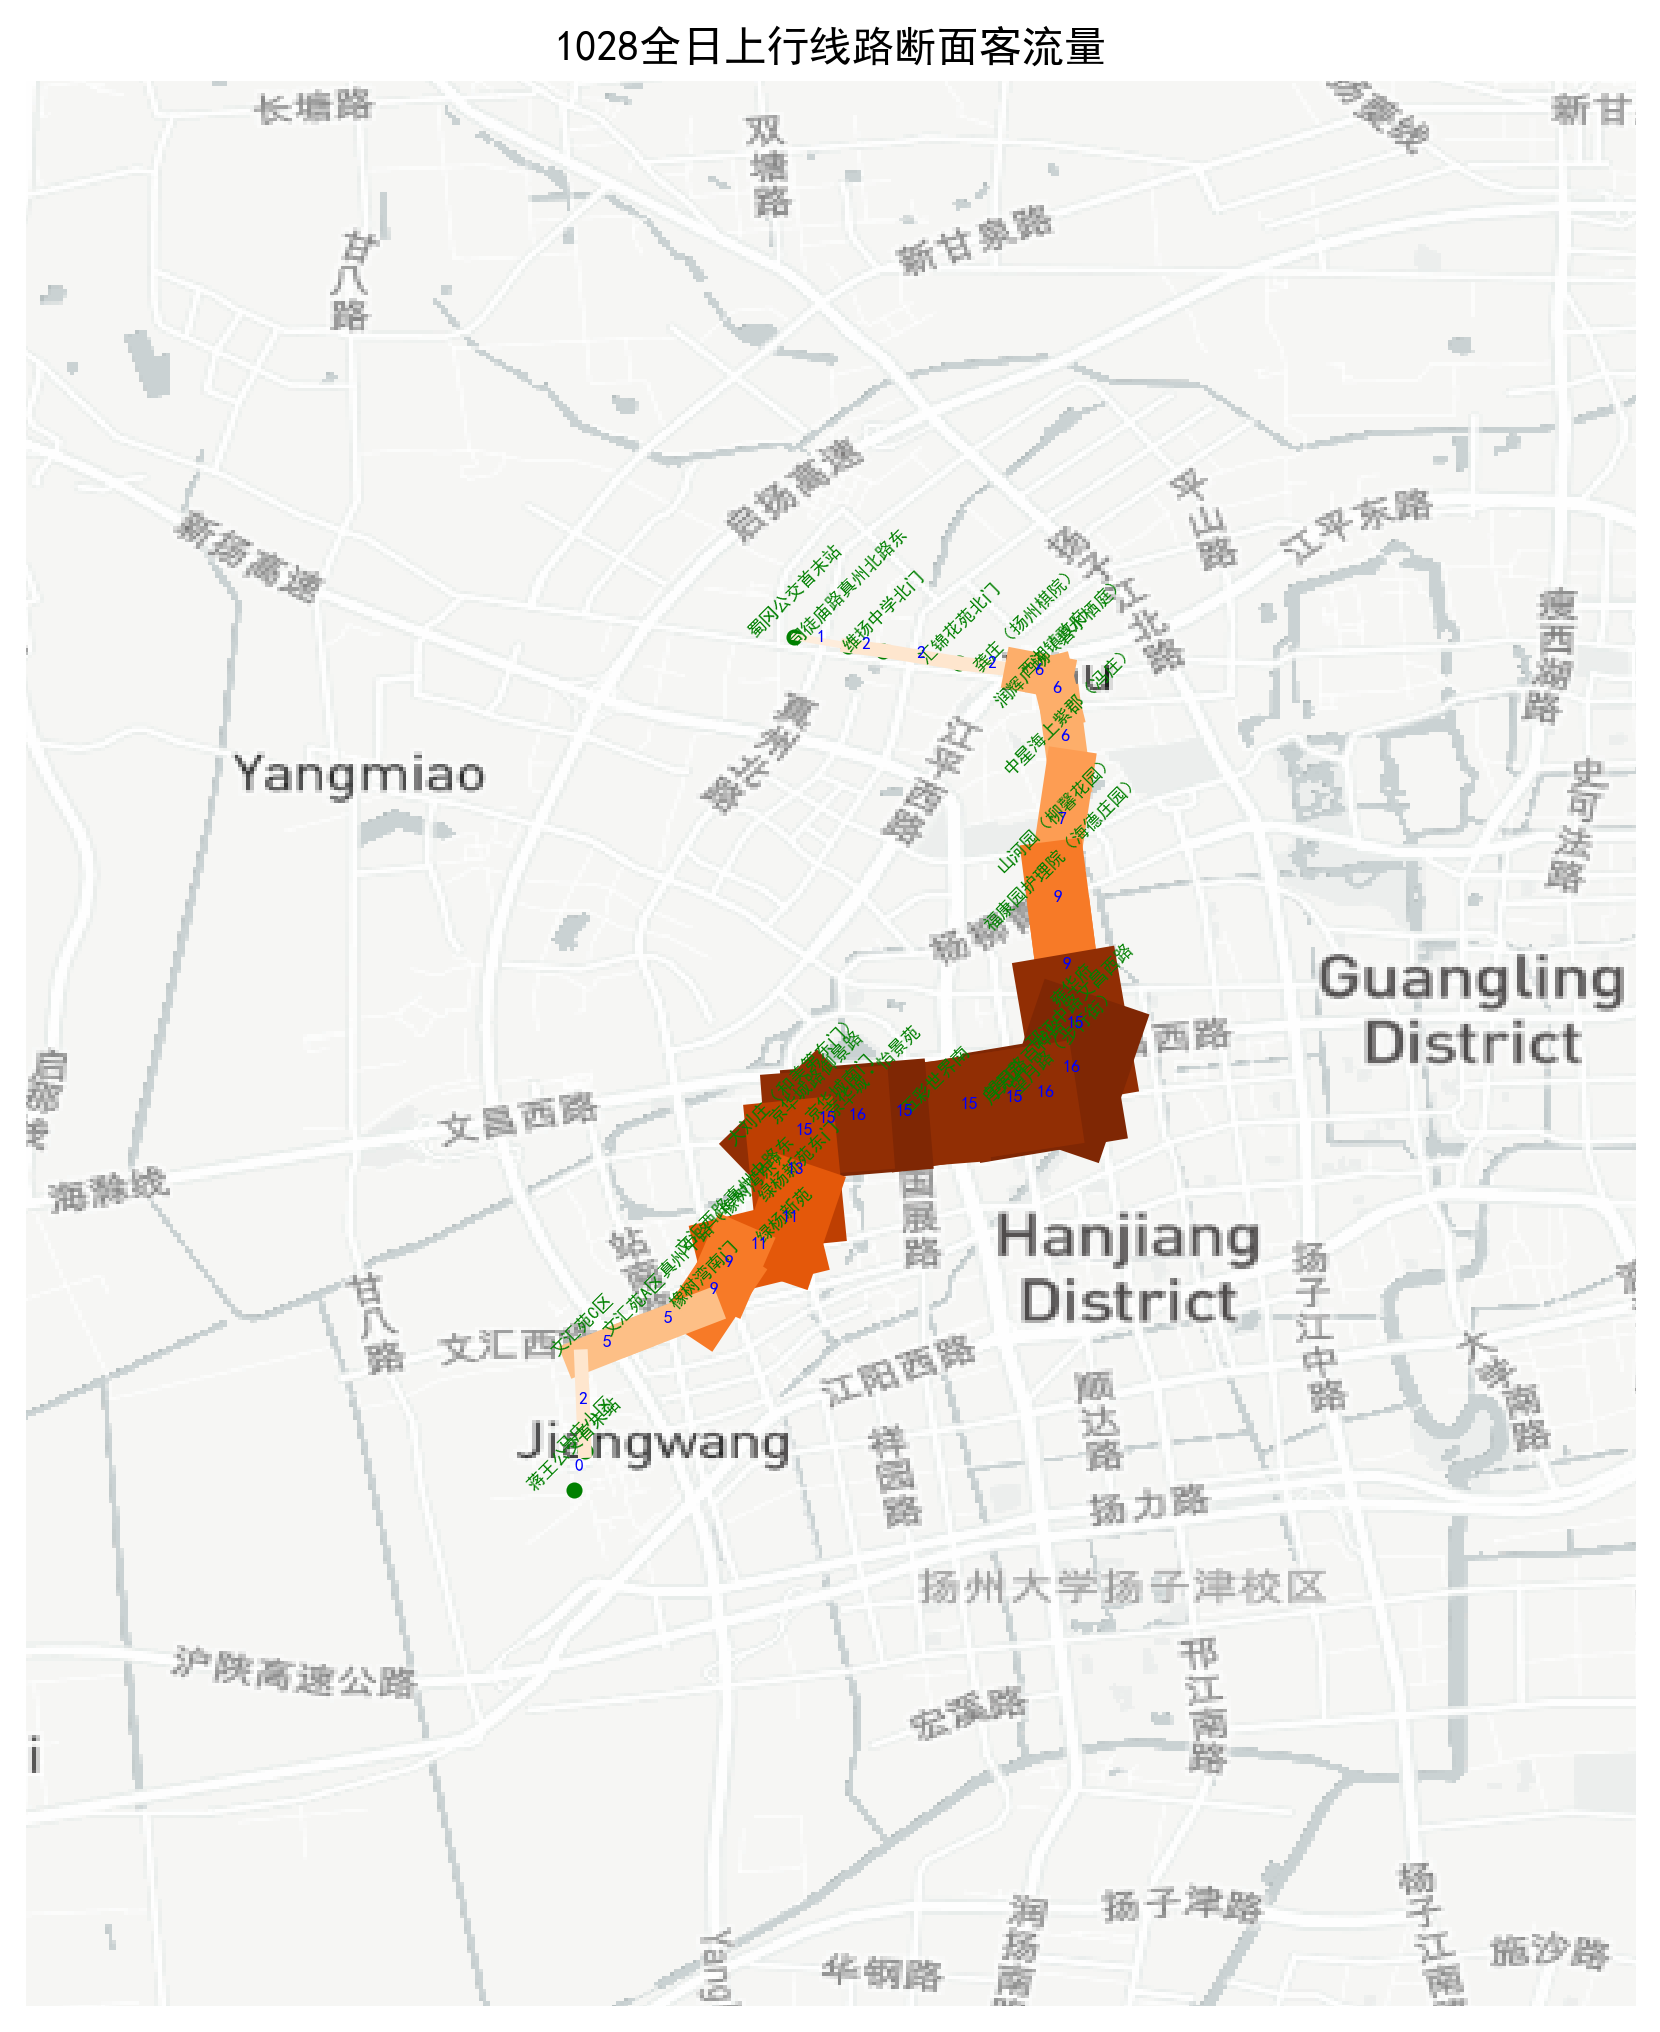

In [4]:
import geopandas
import plot_map
import transbigdata as tbd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
morning_data=sumduan
print(len(morning_data))
fig     = plt.figure(1,(10,10),dpi =255)    
ax      = plt.subplot(111)
plt.sca(ax)
ax.set_title(str(xianlu)+'全日上行线路断面客流量')
tbd.plot_map(plt,bounds=[118.4,32.2,119.8,33.1],zoom=12,style=4)   #设置底图
#绘制行政区划，底图为白色，边框为黑色，宽度为0.5
#hz.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.1)
 
import matplotlib

#设置colormap的数据
vmax = max(morning_data['断面客流量'])
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'Oranges'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)
 
#绘制OD
plt.plot(morning_data['前站经度'],morning_data['前站纬度'],color = 'grey',linewidth=0.5)###绘制线路SHP
#p1=plt.scatter(TIME['LONGITUDE'],TIME['LATITUDE'],marker='.',s=5,color = 'grey')


for i in range(0,len(morning_data)):
    #设定第i条线的color和linewidth
    color_i=cmap(norm(morning_data['断面客流量'].iloc[i]))
    linewidth_i=norm((morning_data['断面客流量'].iloc[i])/morning_data['断面客流量'].max())*500
    #绘制
    plt.plot([morning_data['前站经度'].iloc[i],morning_data['后站经度'].iloc[i]],
             [morning_data['前站纬度'].iloc[i],morning_data['后站纬度'].iloc[i]],
             color=color_i,linewidth=linewidth_i)

plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
#cax = plt.axes([0.01, 0.001, 0.01, 0.001])
#plt.colorbar(cax=cax)
#district=district.drop_duplicates(subset=['STATIONNAME'],keep='first')

#标注区域文字
#标注站点名称
d=stop2['LONGITUDE']
e=stop2['LATITUDE']
f=stop2['STATIONNAME']
for g,h,k in zip(d,e,f):
    plt.text(g,h,k,ha='center',rotation='45',fontsize=5,color='green')

#标注载客量
d1=(morning_data['前站经度']+morning_data['后站经度'])/2
e1=(morning_data['前站纬度']+morning_data['后站纬度'])/2
f1=morning_data['断面客流量']

for g,h,k in zip(d1,e1,f1):
    plt.text(g,h,k,ha='center',rotation='0',fontsize=5,color='blue')


p1=plt.scatter(d,e,marker='.',s=50,color = 'g')##绘制站点坐标点




#然后要把镜头调整回，不然镜头就在imshow那里了
a=min(morning_data['前站经度'])-0.05
b=max(morning_data['前站经度'])+0.05
a1=min(morning_data['前站纬度'])-0.05
b1=max(morning_data['前站纬度'])+0.05
ax.set_xlim(a,b)
ax.set_ylim(a1,b1)
 

#import seaborn as sns
#fig     = plt.figure(1,(7,4),dpi = 250)    
#ax1      = plt.subplot(111)
#plt.savefig(os.path.join(r'F:\data\扬州公交\手机信令梳理\5月6号\匹配廊道图\\'+str(xianlu)+'上行'+'.jpg'))

#plt.xticks(range(0,24*3600+1,3600),range(24+1))

#plt.xlim(0*3600,23*3600)
plt.axis('off')
plt.show()

#p1=plt.scatter(TIME['LONGITUDE'],TIME['LATITUDE'],marker='.',s=5,color = 'g')
#plt.show()

In [5]:
##先形成第一辆车的上行数据
for checi in range(3,4): 
#for checi in range(1,2):   
    checi=checi
    dir_count = 0
    file_count = 0
    for root, dirs, filenames in os.walk(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)):
        for dir in dirs:
            dir_count += 1
        for file in filenames:
            file_count += 1
    print ('dir_count ', dir_count)
    print ('file_count ', file_count)
    if file_count>4:  
        folder = r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'
        files = os.listdir(folder)
        print(files)
        def file_filter(f):
            #if f[-4:] in ['.png', '.bmp']:查找多个格式
            if f[-8:] in ['line.csv']:
                return True
            else:
                return False
        files = list(filter(file_filter, files))###尽量自己使用的时候不要直接把空列表命名为list,不然list会调用出错
        print(files)
        
        
        ###第一趟如果是上行发车，那么以下就是 2,len(files)，否则是 3,len(files)
        #for tangci in range(4,len(files)):   
        for tangci in range(5,len(files)):  
            tangci=tangci
            data=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'流量'+str(tangci)+'.xlsx')
            ##按照站点进行集计
            sum=0
            sumdata=pd.DataFrame()
              #!!某辆车下所有车次的数量
            data2 = data.drop_duplicates(subset=['出发站编号','到达站编号'],keep='first')
            #print(data2)
            data2['站点到达人数']=0
            data2['站点出发人数']=0
            sum=0
            for i in range(0,len(data2)):
                p=0
                pm=0
                for j in range(0,len(data)):
                    if data['出发站编号'].iloc[j]==data2['出发站编号'].iloc[i]:
                        p1=data['到达人数'].iloc[j]
                        p2=data['出发人数'].iloc[j]
                        p=p+p1
                        pm=pm+p2
                data2['站点到达人数'].iloc[i]=p
                data2['站点出发人数'].iloc[i]=pm
                sum=sum+pm 
            data3=data2.loc[:,['出发站编号','到达站编号','出发站','到达站','出发站车辆到站时间','到达站车辆到站时间','站点到达人数','站点出发人数']]
            data3.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点流量'+str(tangci)+'.xlsx',index=None)
            data3=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点流量'+str(tangci)+'.xlsx')
            #print(data3)##索引再次不完整
            #sumdata = sumdata.append(data, ignore_index = True)
            print(sum)
            ##按照到站时间，区别站点到站顺序
            data3.sort_values(by=['出发站车辆到站时间','到达站车辆到站时间'],inplace=True)
            data4=data3.loc[:,['出发站编号','到达站编号','出发站','到达站','出发站车辆到站时间','到达站车辆到站时间','站点出发人数']]
            TIME=pd.read_csv(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'TIME.csv')
            #导入站点数据,先全部匹配再flag筛选，不然匹配结果会出None,原因不明
            stop=pd.read_excel(r'F:\data\扬州公交\上下行站点\\'+str(xianlu)+'.xlsx')
            p1 = pyproj.Proj(init="epsg:4326")#wgs坐标系统的EPSG Code,
            p2 = pyproj.Proj(init="epsg:32651")#UTM 51N坐标系统的EPSG Code\n",
            print(stop)
            lonprj1, latprj1 = pyproj.transform(p1, p2,stop['LONGITUDE'], stop['LATITUDE'])
            stop['lons']=pd.DataFrame(lonprj1)
            stop['lats']=pd.DataFrame(latprj1)
            flag=TIME['上1下0'].iloc[tangci-1]
            if flag==1:
                stop=stop[(stop['站点属性']==flag)|(stop['站点属性']==3)]
                line = pd.read_csv(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+str(tangci)+'_line.csv',encoding='utf-8')
                line=line[(line['LONGITUDE']!=0)&(line['LONGITUDE']!=None)]
                #lonprj, latprj = pyproj.transform(p1, p2,line['LONGITUDE'], line['LATITUDE'])
                #line['lons']=pd.DataFrame(lonprj)
                #line['lats']=pd.DataFrame(latprj)
                print(stop)
                #print(line)
                import math
                ###将所有站点匹配到最近的轨迹点上
                match=[]
                nearestd=[]
                stop.reset_index(drop=True,inplace=True) 
                line.reset_index(drop=True,inplace=True) 
                for k in range(0,len(stop)):###range写法要求索引连续完整
                    distance=[]
                    x2 = stop['lons'].iloc[k]
                    y2 = stop['lats'].iloc[k]
                    for i in range(0,len(line)):        
                        x1 = line['lons'].iloc[i]
                        y1 = line['lats'].iloc[i]
                        #print(math.sqrt((x2-x1)**2+(y2-y1)**2))
                        distance.append(math.sqrt((x2-x1)**2+(y2-y1)**2))
                        #print(distance)
                        #print(len(distance))
                    # 求列表最小值及索引
                    min_value = min(distance) # 求列表最小值
                    #print(min_value)
                    min_idx = distance.index(min_value) # 求最小值对应索引
                    nearestd.append(min_value)
                    match.append(min_idx)
                    #print('match')
                    #print(match)
                ###最近轨迹点整理
                stop['最近轨迹点索引']=match
                stop['最近点距离']=nearestd
                stop['RECDATETIME']=0
                for k in range(0,len(stop)):
                    sy=stop['最近轨迹点索引'].iloc[k]
                    stop['RECDATETIME'].loc[k]=line['RECDATETIME'].iloc[sy]
                print('站点最近轨迹点匹配完毕')
                #转换时间格式，以便下一步计算
                #在这之前需要排个序,##以空格划分日期和时间
                #标准时间的换算，相对00：00：00过了多少秒
                stop['time_st'] = stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[0]).astype('int')*3600+\
                stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[1]).astype('int')*60+\
                stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[2]).astype('int')
                stop.sort_values(by='time_st',inplace=True)
                stop2=stop.loc[:,['STATIONNO','STATIONNAME','time_st','LONGITUDE','LATITUDE']]
                #stop2.reset_index(drop=True,inplace=True) 
                stop2.reset_index(drop=True,inplace=True) 
                duanmian=stop2
                duanmian['前站编号']=None
                duanmian['前站名称']=None
                duanmian['前站到站时间']=None
                duanmian['后站编号']=None
                duanmian['后站名称']=None
                duanmian['后站到站时间']=None
                duanmian['前站经度']=None
                duanmian['前站纬度']=None
                duanmian['后站经度']=None
                duanmian['后站纬度']=None
                for i in  range(0,len(stop2)-1):
                    k=i+1
                    duanmian['前站编号'].iloc[i]=stop2['STATIONNO'].iloc[i]
                    duanmian['后站编号'].iloc[i]=stop2['STATIONNO'].iloc[k]
                    #list2.append(stop2.loc[[k],['STATIONNO']])
                    duanmian['前站名称'].iloc[i]=stop2['STATIONNAME'].iloc[i]
                    duanmian['后站名称'].iloc[i]=stop2['STATIONNAME'].iloc[k]
                    #list4.append(stop2.loc[[k],['STATIONNAME']])
                    duanmian['前站到站时间'].iloc[i]=stop2['time_st'].iloc[i]
                    duanmian['后站到站时间'].iloc[i]=stop2['time_st'].iloc[k]
                    duanmian['前站经度'].iloc[i]=stop2['LONGITUDE'].iloc[i]
                    duanmian['后站经度'].iloc[i]=stop2['LONGITUDE'].iloc[k]
                    duanmian['前站纬度'].iloc[i]=stop2['LATITUDE'].iloc[i]
                    duanmian['后站纬度'].iloc[i]=stop2['LATITUDE'].iloc[k]
                    #list6.append(stop2.loc[[k],['time_st']])
                duan=duanmian.loc[:,['前站编号','前站名称','前站到站时间','前站经度','前站纬度','后站编号','后站名称','后站到站时间','后站经度','后站纬度']]
                duan=duan.loc[0:len(duan)-2]
                data4.reset_index(drop=True,inplace=True) 
                data4['到达站车辆到站时间'] = data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[2]).astype('int')
                data4['出发站车辆到站时间'] = data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[2]).astype('int')
                data4['站间OD']=0
                data5 = data4.drop_duplicates(subset=['出发站编号'],keep='first')
                #print(data5)
                r=data5.index
                for j in r:
                    d=0
                    listx=[]
                    for i in range(0,len(data4)):
                        if data4['出发站编号'].loc[i]==data5['出发站编号'].loc[j]:
                            d=d+1
                            listx.append(i)
                            #print(d)
                        if d!=0:
                            arrive=int(data5['站点出发人数'].loc[j])/d
                            for k in listx:
                                #data4['站间OD'].iloc[k]=math.ceil(arrive)#向上取整
                                data4['站间OD'].iloc[k]=arrive
                data4.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点OD'+str(tangci)+'.xlsx',index=None)
                sumod=sumod.append(data4)
                duan['断面客流量']=0
                duan['前站出发人数']=0
                for i in range(0,len(duan)):
                    s_time=duan['前站到站时间'].iloc[i]
                    e_time=duan['后站到站时间'].iloc[i]
                    p=0
                    for j in range(0,len(data4)):
                        if int(data4['出发站车辆到站时间'].iloc[j])<=s_time:
                            #print('出发站车辆到站时间')
                            #print(data4['出发站车辆到站时间'].iloc[j])
                            #print('s_time')
                            #print(s_time)
                            if int(data4['到达站车辆到站时间'].iloc[j])>=e_time:
                                p=p+int(data4['站间OD'].iloc[j])         
                    duan['断面客流量'].iloc[i]=p
                for i in range(0,len(duan)):
                    s_time=duan['前站到站时间'].iloc[i]
                    e_time=duan['后站到站时间'].iloc[i]
                    for j in range(0,len(data4)):
                        if duan['前站编号'].loc[i]==data4['出发站编号'].loc[j]:
                            duan['前站出发人数'].iloc[i]=int(data4['站点出发人数'].iloc[j])  
                duan.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'段间载客量'+str(tangci)+'.xlsx',index=None)
                duan=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'段间载客量'+str(tangci)+'.xlsx')
                print(duan)
                if len(duan)>4:   
                    for i in range(0,len(sumduan)):
                        sumduan['断面客流量'].iloc[i]=sumduan['断面客流量'].iloc[i]+duan['断面客流量'].iloc[i]
                        sumduan['前站出发人数'].iloc[i]=sumduan['前站出发人数'].iloc[i]+duan['前站出发人数'].iloc[i]
                

print(sumod)
sumduan


dir_count  0
file_count  38
['15min过滤之前1.csv', '15min过滤之前2.csv', '15min过滤之前3.csv', '15min过滤之前4.csv', '15min过滤之前5.csv', '1_line.csv', '1_QSY300.csv', '2_line.csv', '2_QSY300.csv', '3_line.csv', '3_QSY300.csv', '4_line.csv', '4_QSY300.csv', '5_line.csv', '5_QSY300.csv', 'OD1.csv', 'OD2.csv', 'OD3.csv', 'OD4.csv', 'OD5.csv', 'TIME.csv', 'tmp.csv', '段间载客量1.xlsx', '段间载客量2.xlsx', '段间载客量3.xlsx', '段间载客量4.xlsx', '流量1.xlsx', '流量2.xlsx', '流量3.xlsx', '流量4.xlsx', '流量5.xlsx', '站点OD2.xlsx', '站点OD3.xlsx', '站点OD4.xlsx', '站点流量1.xlsx', '站点流量2.xlsx', '站点流量3.xlsx', '站点流量4.xlsx']
['1_line.csv', '2_line.csv', '3_line.csv', '4_line.csv', '5_line.csv']
110
    Unnamed: 0  STATIONNO ROADNAME   STATIONNAME   LONGITUDE   LATITUDE  站点属性
0           19     107573     西边站台         西湖镇政府  119.388873  32.425888     1
1           39     100523     西边站台    润辉广场（碧水栖庭）  119.389558  32.423141     1
2            7     101673     西边站台    中星海上紫郡（冯庄）  119.390348  32.417123     1
3           42     104893     西边站台     山河园（柳馨花园）

站点最近轨迹点匹配完毕
      前站编号          前站名称  前站到站时间        前站经度       前站纬度    后站编号          后站名称  \
0   126374       蜀冈公交首末站   78011  119.365616  32.429459  106372     司徒庙路真州北路东   
1   106372     司徒庙路真州北路东   78088  119.370416  32.428634  125552        维扬中学北门   
2   125552        维扬中学北门   78118  119.373614  32.428208  104292        汇锦花苑北门   
3   104292        汇锦花苑北门   78200  119.380387  32.427079  102144      龚庄（扬州棋院）   
4   102144      龚庄（扬州棋院）   78266  119.386374  32.426366  107573         西湖镇政府   
5   107573         西湖镇政府   78291  119.388873  32.425888  100523    润辉广场（碧水栖庭）   
6   100523    润辉广场（碧水栖庭）   78316  119.389558  32.423141  101673    中星海上紫郡（冯庄）   
7   101673    中星海上紫郡（冯庄）   78382  119.390348  32.417123  104893     山河园（柳馨花园）   
8   104893     山河园（柳馨花园）   78527  119.389028  32.408256  102453  福康园护理院（海德庄园）   
9   102453  福康园护理院（海德庄园）   78577  119.389699  32.403023  108903           雍华府   
10  108903           雍华府   78688  119.390578  32.396268  101133      邗江中路文昌西路   
11  101133      

,前站编号,前站名称,前站到站时间,前站经度,前站纬度,后站编号,后站名称,后站到站时间,后站经度,后站纬度,断面客流量,前站出发人数
0,126374,蜀冈公交首末站,71649,119.365616,32.429459,106372,司徒庙路真州北路东,71755,119.370416,32.428634,1,1
1,106372,司徒庙路真州北路东,71755,119.370416,32.428634,125552,维扬中学北门,71800,119.373614,32.428208,2,1
2,125552,维扬中学北门,71800,119.373614,32.428208,104292,汇锦花苑北门,71896,119.380387,32.427079,3,1
3,104292,汇锦花苑北门,71896,119.380387,32.427079,102144,龚庄（扬州棋院）,71977,119.386374,32.426366,3,0
4,102144,龚庄（扬州棋院）,71977,119.386374,32.426366,107573,西湖镇政府,72012,119.388873,32.425888,7,4
5,107573,西湖镇政府,72012,119.388873,32.425888,100523,润辉广场（碧水栖庭）,72079,119.389558,32.423141,7,0
6,100523,润辉广场（碧水栖庭）,72079,119.389558,32.423141,101673,中星海上紫郡（冯庄）,72181,119.390348,32.417123,7,0
7,101673,中星海上紫郡（冯庄）,72181,119.390348,32.417123,104893,山河园（柳馨花园）,72291,119.389028,32.408256,8,1
8,104893,山河园（柳馨花园）,72291,119.389028,32.408256,102453,福康园护理院（海德庄园）,72443,119.389699,32.403023,11,5
9,102453,福康园护理院（海德庄园）,72443,119.389699,32.403023,108903,雍华府,72559,119.390578,32.396268,11,0


In [6]:
##在第一辆车的基础上进行累计
for checi in range(4,26):   
#for checi in range(2,17):   
    checi=checi
    print('checi')
    print(checi)
    dir_count = 0
    file_count = 0
    for root, dirs, filenames in os.walk(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)):
        for dir in dirs:
            dir_count += 1
        for file in filenames:
            file_count += 1
    print ('dir_count ', dir_count)
    print ('file_count ', file_count)
    if file_count>4:  
        folder = r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'
        files = os.listdir(folder)
        #print(files)
        def file_filter(f):
            #if f[-4:] in ['.png', '.bmp']:查找多个格式
            if f[-8:] in ['line.csv']:
                return True
            else:
                return False
        files = list(filter(file_filter, files))###尽量自己使用的时候不要直接把空列表命名为list,不然list会调用出错
        #print(files)
        for tangci in range(1,len(files)):            
            tangci=tangci
            data=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'流量'+str(tangci)+'.xlsx')
            ##按照站点进行集计
            sum=0
            sumdata=pd.DataFrame()
              #!!某辆车下所有车次的数量
            data2 = data.drop_duplicates(subset=['出发站编号','到达站编号'],keep='first')
            #print(data2)
            data2['站点到达人数']=0
            data2['站点出发人数']=0
            sum=0
            for i in range(0,len(data2)):
                p=0
                pm=0
                for j in range(0,len(data)):
                    if data['出发站编号'].iloc[j]==data2['出发站编号'].iloc[i]:
                        p1=data['到达人数'].iloc[j]
                        p2=data['出发人数'].iloc[j]
                        p=p+p1
                        pm=pm+p2
                data2['站点到达人数'].iloc[i]=p
                data2['站点出发人数'].iloc[i]=pm
                sum=sum+pm 
            data3=data2.loc[:,['出发站编号','到达站编号','出发站','到达站','出发站车辆到站时间','到达站车辆到站时间','站点到达人数','站点出发人数']]
            data3.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点流量'+str(tangci)+'.xlsx',index=None)
            data3=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点流量'+str(tangci)+'.xlsx')
            #print(data3)##索引再次不完整
            #sumdata = sumdata.append(data, ignore_index = True)
            print(sum)
            ##按照到站时间，区别站点到站顺序
            data3.sort_values(by=['出发站车辆到站时间','到达站车辆到站时间'],inplace=True)
            data4=data3.loc[:,['出发站编号','到达站编号','出发站','到达站','出发站车辆到站时间','到达站车辆到站时间','站点出发人数']]
            TIME=pd.read_csv(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'TIME.csv')
            #导入站点数据,先全部匹配再flag筛选，不然匹配结果会出None,原因不明
            stop=pd.read_excel(r'F:\data\扬州公交\上下行站点\\'+str(xianlu)+'.xlsx')
            p1 = pyproj.Proj(init="epsg:4326")#wgs坐标系统的EPSG Code,
            p2 = pyproj.Proj(init="epsg:32651")#UTM 51N坐标系统的EPSG Code\n",
            #print(stop)
            lonprj1, latprj1 = pyproj.transform(p1, p2,stop['LONGITUDE'], stop['LATITUDE'])
            stop['lons']=pd.DataFrame(lonprj1)
            stop['lats']=pd.DataFrame(latprj1)
            flag=TIME['上1下0'].iloc[tangci-1]
            if flag==1:
                stop=stop[(stop['站点属性']==flag)|(stop['站点属性']==3)]
                line = pd.read_csv(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+str(tangci)+'_line.csv',encoding='utf-8')
                line=line[(line['LONGITUDE']!=0)&(line['LONGITUDE']!=None)]
                #lonprj, latprj = pyproj.transform(p1, p2,line['LONGITUDE'], line['LATITUDE'])
                #line['lons']=pd.DataFrame(lonprj)
                #line['lats']=pd.DataFrame(latprj)
                #print(stop)
                #print(line)
                import math
                ###将所有站点匹配到最近的轨迹点上
                match=[]
                nearestd=[]
                stop.reset_index(drop=True,inplace=True) 
                line.reset_index(drop=True,inplace=True) 
                for k in range(0,len(stop)):###range写法要求索引连续完整
                    distance=[]
                    x2 = stop['lons'].iloc[k]
                    y2 = stop['lats'].iloc[k]
                    for i in range(0,len(line)):        
                        x1 = line['lons'].iloc[i]
                        y1 = line['lats'].iloc[i]
                        #print(math.sqrt((x2-x1)**2+(y2-y1)**2))
                        distance.append(math.sqrt((x2-x1)**2+(y2-y1)**2))
                        #print(distance)
                        #print(len(distance))
                    # 求列表最小值及索引
                    min_value = min(distance) # 求列表最小值
                    #print(min_value)
                    min_idx = distance.index(min_value) # 求最小值对应索引
                    nearestd.append(min_value)
                    match.append(min_idx)
                    #print('match')
                    #print(match)
                ###最近轨迹点整理
                stop['最近轨迹点索引']=match
                stop['最近点距离']=nearestd
                stop['RECDATETIME']=0
                for k in range(0,len(stop)):
                    sy=stop['最近轨迹点索引'].iloc[k]
                    stop['RECDATETIME'].loc[k]=line['RECDATETIME'].iloc[sy]
                print('站点最近轨迹点匹配完毕')
                #转换时间格式，以便下一步计算
                #在这之前需要排个序,##以空格划分日期和时间
                #标准时间的换算，相对00：00：00过了多少秒
                stop['time_st'] = stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[0]).astype('int')*3600+\
                stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[1]).astype('int')*60+\
                stop['RECDATETIME'].apply(lambda r:r.split(' ')[1].split(':')[2]).astype('int')
                stop.sort_values(by='time_st',inplace=True)
                stop2=stop.loc[:,['STATIONNO','STATIONNAME','time_st','LONGITUDE','LATITUDE']]
                #stop2.reset_index(drop=True,inplace=True) 
                stop2.reset_index(drop=True,inplace=True) 
                duanmian=stop2
                duanmian['前站编号']=None
                duanmian['前站名称']=None
                duanmian['前站到站时间']=None
                duanmian['后站编号']=None
                duanmian['后站名称']=None
                duanmian['后站到站时间']=None
                duanmian['前站经度']=None
                duanmian['前站纬度']=None
                duanmian['后站经度']=None
                duanmian['后站纬度']=None
                for i in  range(0,len(stop2)-1):
                    k=i+1
                    duanmian['前站编号'].iloc[i]=stop2['STATIONNO'].iloc[i]
                    duanmian['后站编号'].iloc[i]=stop2['STATIONNO'].iloc[k]
                    #list2.append(stop2.loc[[k],['STATIONNO']])
                    duanmian['前站名称'].iloc[i]=stop2['STATIONNAME'].iloc[i]
                    duanmian['后站名称'].iloc[i]=stop2['STATIONNAME'].iloc[k]
                    #list4.append(stop2.loc[[k],['STATIONNAME']])
                    duanmian['前站到站时间'].iloc[i]=stop2['time_st'].iloc[i]
                    duanmian['后站到站时间'].iloc[i]=stop2['time_st'].iloc[k]
                    duanmian['前站经度'].iloc[i]=stop2['LONGITUDE'].iloc[i]
                    duanmian['后站经度'].iloc[i]=stop2['LONGITUDE'].iloc[k]
                    duanmian['前站纬度'].iloc[i]=stop2['LATITUDE'].iloc[i]
                    duanmian['后站纬度'].iloc[i]=stop2['LATITUDE'].iloc[k]
                    #list6.append(stop2.loc[[k],['time_st']])
                duan=duanmian.loc[:,['前站编号','前站名称','前站到站时间','前站经度','前站纬度','后站编号','后站名称','后站到站时间','后站经度','后站纬度']]
                duan=duan.loc[0:len(duan)-2]
                data4.reset_index(drop=True,inplace=True) 
                data4['到达站车辆到站时间'] = data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                data4['到达站车辆到站时间'].apply(lambda r:r.split(':')[2]).astype('int')
                data4['出发站车辆到站时间'] = data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                data4['出发站车辆到站时间'].apply(lambda r:r.split(':')[2]).astype('int')
                data4['站间OD']=0
                data5 = data4.drop_duplicates(subset=['出发站编号'],keep='first')
                #print(data5)
                r=data5.index
                for j in r:
                    d=0
                    listx=[]
                    for i in range(0,len(data4)):
                        if data4['出发站编号'].loc[i]==data5['出发站编号'].loc[j]:
                            d=d+1
                            listx.append(i)
                            #print(d)
                        if d!=0:
                            arrive=int(data5['站点出发人数'].loc[j])/d
                            for k in listx:
                                #data4['站间OD'].iloc[k]=math.ceil(arrive)#向上取整
                                data4['站间OD'].iloc[k]=arrive
                data4.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'站点OD'+str(tangci)+'.xlsx',index=None)
                sumod=sumod.append(data4)
                print('data4')
                print(sumod)
                print('data4')
                print(sumod)
                duan['断面客流量']=0
                duan['前站出发人数']=0
                for i in range(0,len(duan)):
                    s_time=duan['前站到站时间'].iloc[i]
                    e_time=duan['后站到站时间'].iloc[i]
                    p=0
                    for j in range(0,len(data4)):
                        if int(data4['出发站车辆到站时间'].iloc[j])<=s_time:
                            #print('出发站车辆到站时间')
                            #print(data4['出发站车辆到站时间'].iloc[j])
                            #print('s_time')
                            #print(s_time)
                            if int(data4['到达站车辆到站时间'].iloc[j])>=e_time:
                                p=p+int(data4['站间OD'].iloc[j])         
                    duan['断面客流量'].iloc[i]=p
                for i in range(0,len(duan)):
                    s_time=duan['前站到站时间'].iloc[i]
                    e_time=duan['后站到站时间'].iloc[i]
                    for j in range(0,len(data4)):
                        if duan['前站编号'].loc[i]==data4['出发站编号'].loc[j]:
                            duan['前站出发人数'].iloc[i]=int(data4['站点出发人数'].iloc[j])  
                duan.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'段间载客量'+str(tangci)+'.xlsx',index=None)
                duan=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\\'+'NEW'+str(xianlu)+'\\'+str(checi)+'\\'+'段间载客量'+str(tangci)+'.xlsx')
                if len(duan)>3:
                    for i in range(0,len(sumduan)):
                        sumduan['断面客流量'].iloc[i]=sumduan['断面客流量'].iloc[i]+duan['断面客流量'].iloc[i]
                        sumduan['前站出发人数'].iloc[i]=sumduan['前站出发人数'].iloc[i]+duan['前站出发人数'].iloc[i]
sumduan

checi
4
dir_count  0
file_count  39
49
站点最近轨迹点匹配完毕
data4
     出发站编号   到达站编号           出发站         到达站  出发站车辆到站时间  到达站车辆到站时间  站点出发人数  \
0   126374  104893       蜀冈公交首末站   山河园（柳馨花园）      71649      72291       1   
1   106372  111264     司徒庙路真州北路东       文汇苑C区      71755      73654       1   
2   102144  100344      龚庄（扬州棋院）      望月路百祥路      71977      72800       4   
3   102144  109034      龚庄（扬州棋院）         月亮园      71977      72845       4   
4   102144  104194      龚庄（扬州棋院）       京华城南门      71977      73070       4   
5   102144  111264      龚庄（扬州棋院）       文汇苑C区      71977      73654       4   
6   101673  100344    中星海上紫郡（冯庄）      望月路百祥路      72181      72800       1   
7   104893  104214     山河园（柳馨花园）     京华城·怡景苑      72291      73005       4   
8   104893  109704     山河园（柳馨花园）   文汇西路真州中路东      72291      73362       4   
9   104893  114704     山河园（柳馨花园）       橡树湾南门      72291      73507       4   
10  108903  101073           雍华府  大刘庄（和美第东门）      72559      73196       7   
11  108

85
71
站点最近轨迹点匹配完毕
data4
     出发站编号   到达站编号         出发站        到达站  出发站车辆到站时间  到达站车辆到站时间  站点出发人数  站间OD
0   126374  104893     蜀冈公交首末站  山河园（柳馨花园）      71649      72291       1   1.0
1   106372  111264   司徒庙路真州北路东      文汇苑C区      71755      73654       1   1.0
2   102144  100344    龚庄（扬州棋院）     望月路百祥路      71977      72800       4   1.0
3   102144  109034    龚庄（扬州棋院）        月亮园      71977      72845       4   1.0
4   102144  104194    龚庄（扬州棋院）      京华城南门      71977      73070       4   1.0
..     ...     ...         ...        ...        ...        ...     ...   ...
17  100264  112044       五彩世界南       马庄小区      74842      75882       1   1.0
18  104214  109724     京华城·怡景苑      文汇苑A区      74998      75699       5   2.5
19  104214  112044     京华城·怡景苑       马庄小区      74998      75882       5   2.5
20  101073  112044  大刘庄（和美第东门）       马庄小区      75220      75882       1   1.0
21  114853  112044      绿杨新苑东门       马庄小区      75281      75882       2   2.0

[69 rows x 8 columns]
data4
     出发站编号 

38
checi
7
dir_count  0
file_count  39
0
100
站点最近轨迹点匹配完毕
data4
     出发站编号   到达站编号        出发站         到达站  出发站车辆到站时间  到达站车辆到站时间  站点出发人数  站间OD
0   126374  104893    蜀冈公交首末站   山河园（柳馨花园）      71649      72291       1   1.0
1   106372  111264  司徒庙路真州北路东       文汇苑C区      71755      73654       1   1.0
2   102144  100344   龚庄（扬州棋院）      望月路百祥路      71977      72800       4   1.0
3   102144  109034   龚庄（扬州棋院）         月亮园      71977      72845       4   1.0
4   102144  104194   龚庄（扬州棋院）       京华城南门      71977      73070       4   1.0
..     ...     ...        ...         ...        ...        ...     ...   ...
18  109034  109724        月亮园       文汇苑A区      71160      72132       1   1.0
19  100264  114693      五彩世界南  真州中路（橡树湾东）      71241      71901       1   1.0
20  104214  111264    京华城·怡景苑       文汇苑C区      71397      72192       4   2.0
21  104214  112044    京华城·怡景苑        马庄小区      71397      72343       4   2.0
22  114853  112044     绿杨新苑东门        马庄小区      71684      72343       3   3.0



163
87
站点最近轨迹点匹配完毕
data4
     出发站编号   到达站编号         出发站         到达站  出发站车辆到站时间  到达站车辆到站时间  站点出发人数  站间OD
0   126374  104893     蜀冈公交首末站   山河园（柳馨花园）      71649      72291       1   1.0
1   106372  111264   司徒庙路真州北路东       文汇苑C区      71755      73654       1   1.0
2   102144  100344    龚庄（扬州棋院）      望月路百祥路      71977      72800       4   1.0
3   102144  109034    龚庄（扬州棋院）         月亮园      71977      72845       4   1.0
4   102144  104194    龚庄（扬州棋院）       京华城南门      71977      73070       4   1.0
..     ...     ...         ...         ...        ...        ...     ...   ...
14  100344  114693      望月路百祥路  真州中路（橡树湾东）      79773      80483       4   2.0
15  100344  112044      望月路百祥路        马庄小区      79773      80855       4   2.0
16  104214  111264     京华城·怡景苑       文汇苑C区      80034      80703      10   5.0
17  104214  112044     京华城·怡景苑        马庄小区      80034      80855      10   5.0
18  101073  112044  大刘庄（和美第东门）        马庄小区      80189      80855       1   1.0

[293 rows x 8 columns]
dat

,前站编号,前站名称,前站到站时间,前站经度,前站纬度,后站编号,后站名称,后站到站时间,后站经度,后站纬度,断面客流量,前站出发人数
0,126374,蜀冈公交首末站,71649,119.365616,32.429459,106372,司徒庙路真州北路东,71755,119.370416,32.428634,6,3
1,106372,司徒庙路真州北路东,71755,119.370416,32.428634,125552,维扬中学北门,71800,119.373614,32.428208,19,13
2,125552,维扬中学北门,71800,119.373614,32.428208,104292,汇锦花苑北门,71896,119.380387,32.427079,38,20
3,104292,汇锦花苑北门,71896,119.380387,32.427079,102144,龚庄（扬州棋院）,71977,119.386374,32.426366,43,5
4,102144,龚庄（扬州棋院）,71977,119.386374,32.426366,107573,西湖镇政府,72012,119.388873,32.425888,77,41
5,107573,西湖镇政府,72012,119.388873,32.425888,100523,润辉广场（碧水栖庭）,72079,119.389558,32.423141,77,0
6,100523,润辉广场（碧水栖庭）,72079,119.389558,32.423141,101673,中星海上紫郡（冯庄）,72181,119.390348,32.417123,88,11
7,101673,中星海上紫郡（冯庄）,72181,119.390348,32.417123,104893,山河园（柳馨花园）,72291,119.389028,32.408256,95,7
8,104893,山河园（柳馨花园）,72291,119.389028,32.408256,102453,福康园护理院（海德庄园）,72443,119.389699,32.403023,118,29
9,102453,福康园护理院（海德庄园）,72443,119.389699,32.403023,108903,雍华府,72559,119.390578,32.396268,133,17


In [7]:
data=pd.read_csv(r'F:\data\扬州公交\站点重复统计.csv',delimiter=",",encoding='utf-8')
data=data[data['STATIONNO']!='STATIONNO']
data.sort_values(by='STATIONNO')
data[['STATIONNO','route']]= data[['STATIONNO','route']].apply(pd.to_numeric)
#白班车
data=data[(data['route']!=1028)&(data['route']!=2001)&
          (data['route']!=2008)&(data['route']!=2018)&
          (data['route']!=2020)&(data['route']!=2023)&
          (data['route']!=2026)&(data['route']!=2029)&
          (data['route']!=2066)&(data['route']!=2088)&
          (data['route']!=2099)&(data['route']!=2106)]

#夜班车
data=data[data['route']==1028|data['route']==2001|
          data['route']==2008|data['route']==2018|
          data['route']==2020|data['route']==2023|
          data['route']==2026|data['route']==2029|
          data['route']==2066|data['route']==2088|
          data['route']==2099|data['route']==2106]

In [9]:
sumduan1=sumduan
#站点与全网站点查重后均分
import math
for i in range(0,len(sumduan1)):
    qianid=sumduan1['前站编号'].iloc[i]
    houid=sumduan1['后站编号'].iloc[i]
    qianc=[]
    houc=[]
    #print('i')
    #print(i)
    for k in range(0,len(data)):
        if data['STATIONNO'].iloc[k]==qianid:
            qianc.append(data['route'].iloc[k])            
        if data['STATIONNO'].iloc[k]==houid:
            houc.append(data['route'].iloc[k])
    #print('qianc')
    #print(qianc)
    #print('houc')
    #print(houc) 
    c=[x for x in qianc if x in houc]
    #print(c)
    cl=len(c)  
    #print(cl)
    #print(sumduan1['断面客流量'].iloc[i])
   # sumduan1['断面客流量'].iloc[i]=math.ceil(sumduan1['断面客流量'].iloc[i]/cl)
    sumduan1['断面客流量'].iloc[i]=sumduan1['断面客流量'].iloc[i]/cl
    #print(sumduan1['断面客流量'].iloc[i])
sumduan=sumduan1

sumod=sumod[sumod['站间OD']>=1]

In [11]:
##OD对集计
data6 = sumod.drop_duplicates(subset=['出发站编号','到达站编号'],keep='first')
#print(data2)
data6['站点出发人数']=0
data6['站间OD']=0
sum=0
for i in range(0,len(data6)):
    pm=0
    p=0
    for j in range(0,len(sumod)):
        if sumod['出发站编号'].iloc[j]==data6['出发站编号'].iloc[i]:
            p2=sumod['站点出发人数'].iloc[j]
            pm=pm+p2
            if sumod['到达站编号'].iloc[j]==data6['到达站编号'].iloc[i]:
                p1=sumod['站间OD'].iloc[j]
                p=p+p1
    data6['站点出发人数'].iloc[i]=pm
    data6['站间OD'].iloc[i]=p
lineodsum=data6
##站点OD对与全网查重后均分
import math
for i in range(0,len(lineodsum)):
    qianid=lineodsum['出发站编号'].iloc[i]
    houid=lineodsum['到达站编号'].iloc[i]
    qianc=[]
    houc=[]
    #print('i')
    #print(i)
    for k in range(0,len(data)):
        if data['STATIONNO'].iloc[k]==qianid:
            qianc.append(data['route'].iloc[k])            
        if data['STATIONNO'].iloc[k]==houid:
            houc.append(data['route'].iloc[k])
    #print('qianc')
    #print(qianc)
    #print('houc')
    #print(houc) 
    c=[x for x in qianc if x in houc]
    #print(c)
    cl=len(c)  
    #print(cl)
    #print(sumduan['载客量'].iloc[i])
    #lineodsum['站间OD'].iloc[i]=math.ceil(lineodsum['站间OD'].iloc[i]/cl)
    lineodsum['站间OD'].iloc[i]=lineodsum['站间OD'].iloc[i]/cl
    #print(sumduan['载客量'].iloc[i])
lineodsum

,出发站编号,到达站编号,出发站,到达站,出发站车辆到站时间,到达站车辆到站时间,站点出发人数,站间OD
0,126374,104893,蜀冈公交首末站,山河园（柳馨花园）,71649,72291,3,1.0
1,106372,111264,司徒庙路真州北路东,文汇苑C区,71755,73654,13,inf
2,102144,100344,龚庄（扬州棋院）,望月路百祥路,71977,72800,122,inf
3,102144,109034,龚庄（扬州棋院）,月亮园,71977,72845,122,inf
4,102144,104194,龚庄（扬州棋院）,京华城南门,71977,73070,122,inf
...,...,...,...,...,...,...,...,...
0,106372,101073,司徒庙路真州北路东,大刘庄（和美第东门）,76857,78350,13,inf
22,101073,111264,大刘庄（和美第东门）,文汇苑C区,72384,73005,6,inf
1,106372,104214,司徒庙路真州北路东,京华城·怡景苑,78746,80034,13,inf
4,102144,114853,龚庄（扬州棋院）,绿杨新苑东门,78996,80266,122,inf


In [12]:
###绘制所有上行站点的廊道图

28


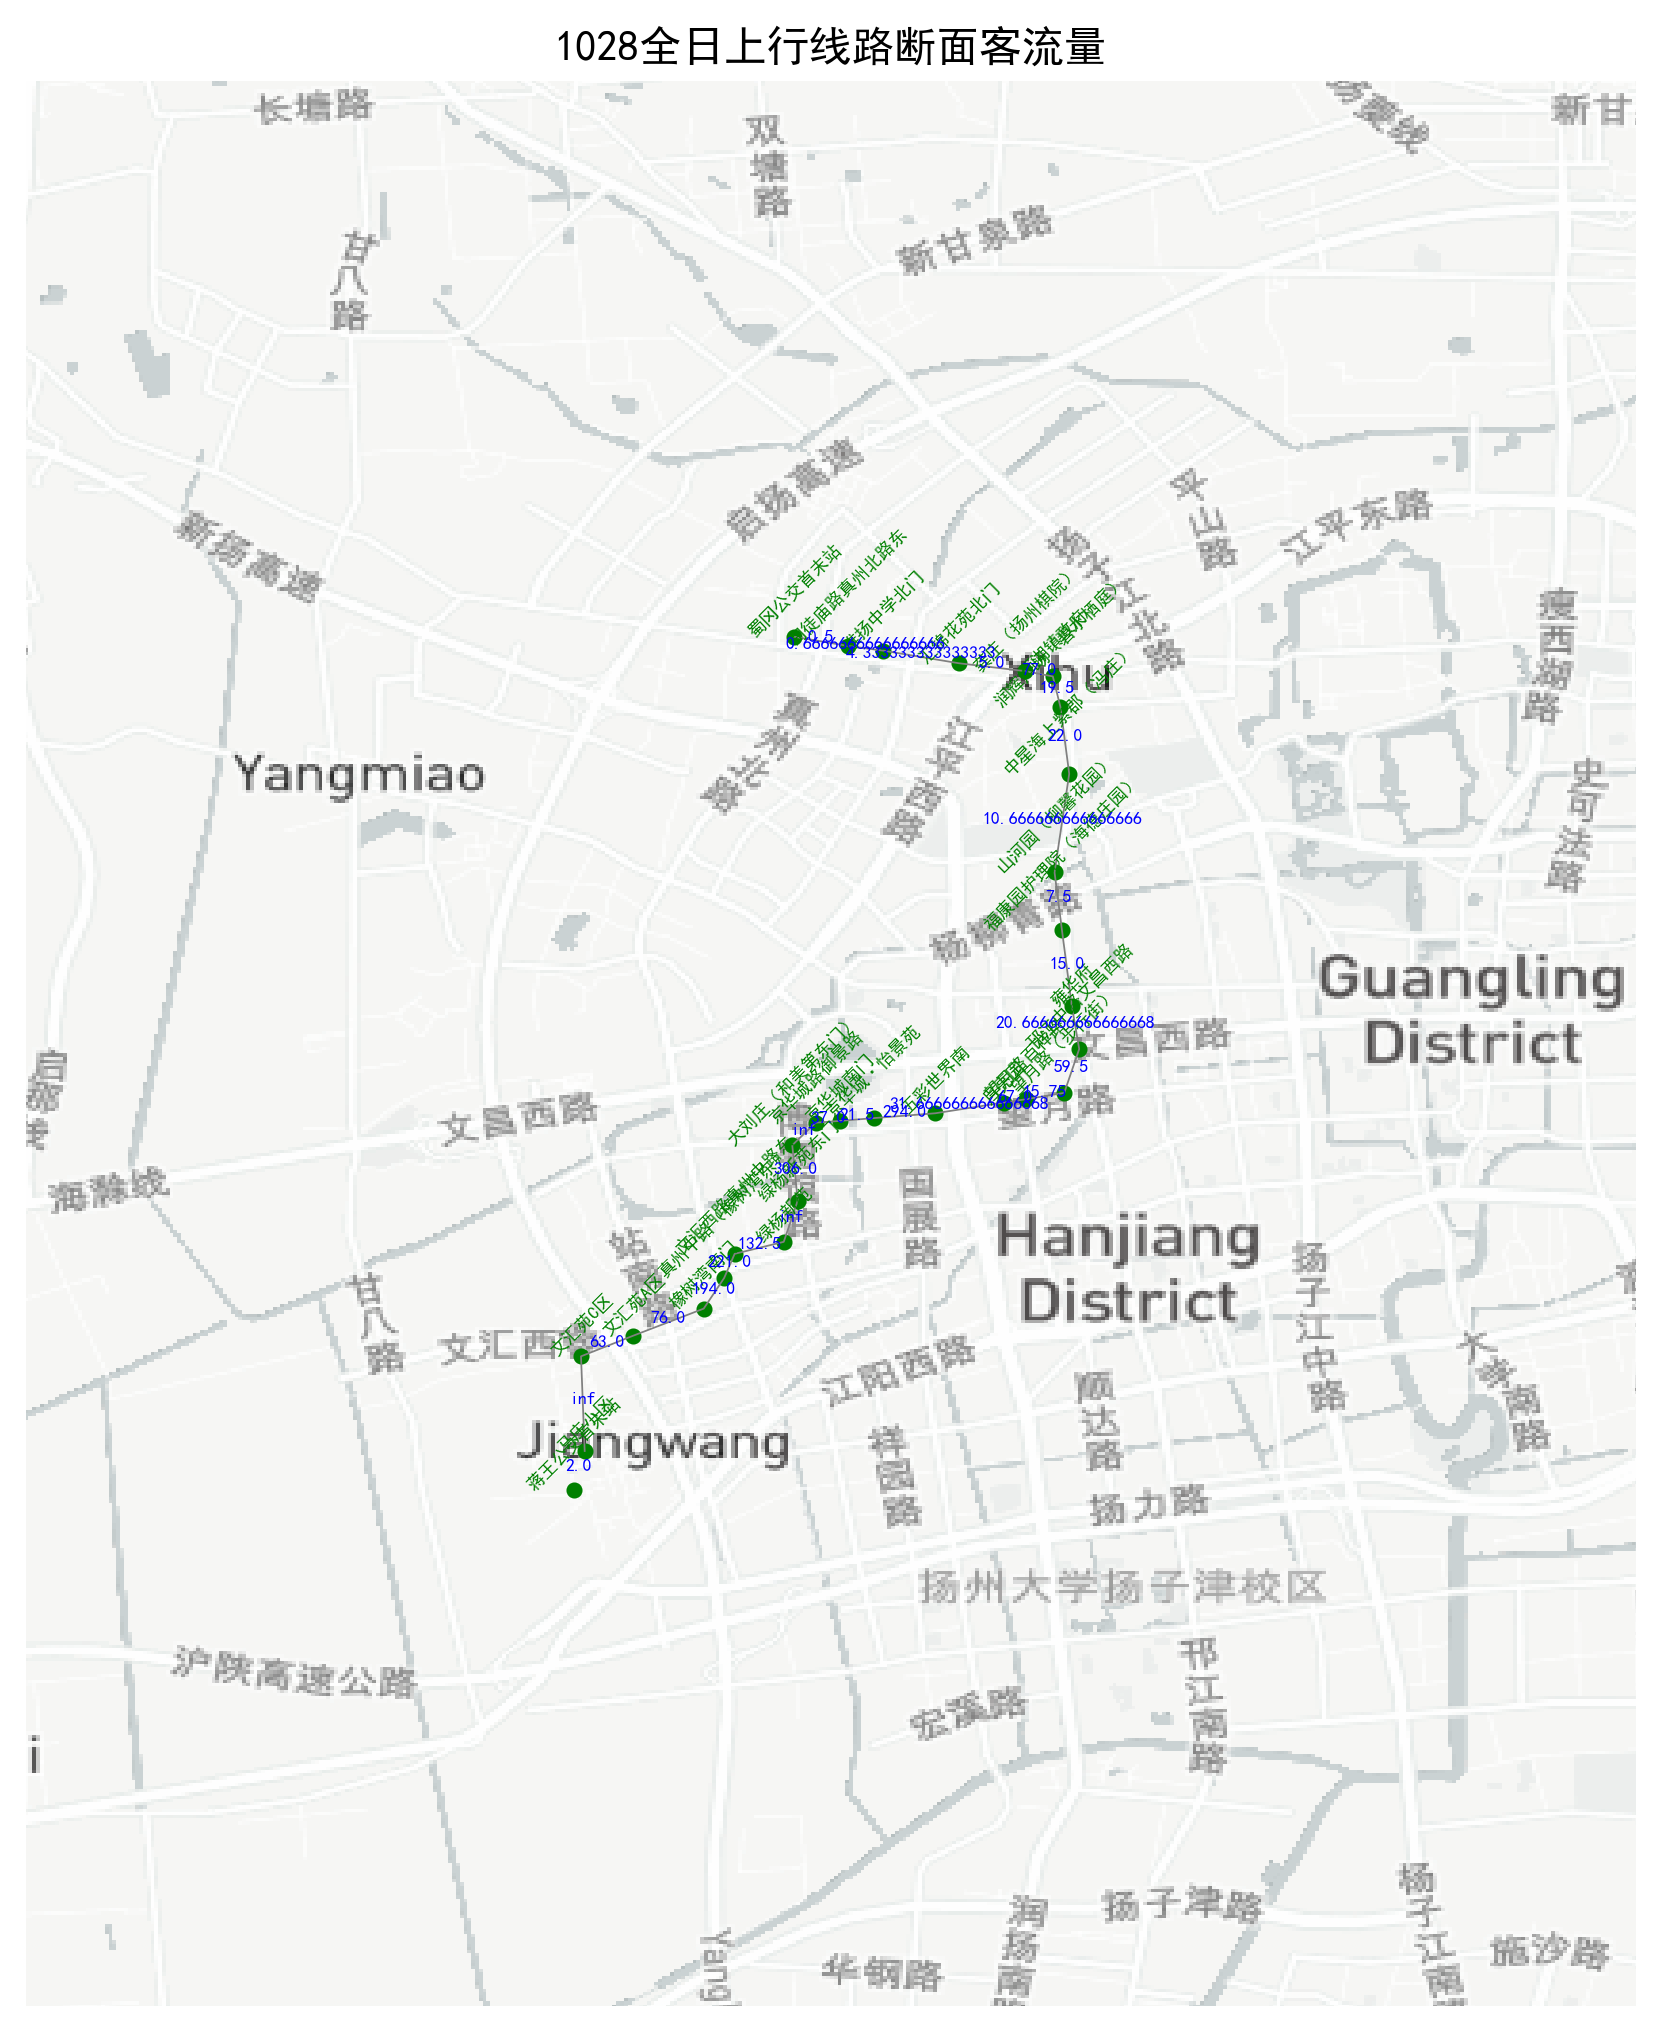

In [13]:
import geopandas
import plot_map
import transbigdata as tbd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
morning_data=sumduan
print(len(morning_data))
fig     = plt.figure(1,(10,10),dpi =255)    
ax      = plt.subplot(111)
plt.sca(ax)
ax.set_title(str(xianlu)+'全日上行线路断面客流量')
tbd.plot_map(plt,bounds=[118.4,32.2,119.8,33.1],zoom=12,style=4)   #设置底图
#绘制行政区划，底图为白色，边框为黑色，宽度为0.5
#hz.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.1)
 
import matplotlib

#设置colormap的数据
vmax = max(morning_data['断面客流量'])
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'Oranges'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)
 
#绘制OD
plt.plot(morning_data['前站经度'],morning_data['前站纬度'],color = 'grey',linewidth=0.5)###绘制线路SHP
#p1=plt.scatter(TIME['LONGITUDE'],TIME['LATITUDE'],marker='.',s=5,color = 'grey')


for i in range(0,len(morning_data)):
    #设定第i条线的color和linewidth
    color_i=cmap(norm(morning_data['断面客流量'].iloc[i]))
    linewidth_i=norm((morning_data['断面客流量'].iloc[i])/morning_data['断面客流量'].max())*9999
    #绘制
    plt.plot([morning_data['前站经度'].iloc[i],morning_data['后站经度'].iloc[i]],
             [morning_data['前站纬度'].iloc[i],morning_data['后站纬度'].iloc[i]],
             color=color_i,linewidth=linewidth_i)

plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
#cax = plt.axes([0.01, 0.001, 0.01, 0.001])
#plt.colorbar(cax=cax)
#district=district.drop_duplicates(subset=['STATIONNAME'],keep='first')

#标注区域文字
#标注站点名称
d=stop2['LONGITUDE']
e=stop2['LATITUDE']
f=stop2['STATIONNAME']
for g,h,k in zip(d,e,f):
    plt.text(g,h,k,ha='center',rotation='45',fontsize=5,color='green')

#标注载客量
d1=(morning_data['前站经度']+morning_data['后站经度'])/2
e1=(morning_data['前站纬度']+morning_data['后站纬度'])/2
f1=morning_data['断面客流量']

for g,h,k in zip(d1,e1,f1):
    plt.text(g,h,k,ha='center',rotation='0',fontsize=5,color='blue')


p1=plt.scatter(d,e,marker='.',s=50,color = 'g')##绘制站点坐标点




#然后要把镜头调整回，不然镜头就在imshow那里了
a=min(morning_data['前站经度'])-0.05
b=max(morning_data['前站经度'])+0.05
a1=min(morning_data['前站纬度'])-0.05
b1=max(morning_data['前站纬度'])+0.05
ax.set_xlim(a,b)
ax.set_ylim(a1,b1)
 

#import seaborn as sns
#fig     = plt.figure(1,(7,4),dpi = 250)    
#ax1      = plt.subplot(111)
plt.savefig(os.path.join(r'F:\data\扬州公交\手机信令梳理\5月6号\匹配廊道图\\'+str(xianlu)+'上行'+'.jpg'))

#plt.xticks(range(0,24*3600+1,3600),range(24+1))

#plt.xlim(0*3600,23*3600)
plt.axis('off')
plt.show()

#p1=plt.scatter(TIME['LONGITUDE'],TIME['LATITUDE'],marker='.',s=5,color = 'g')
#plt.show()

In [14]:
sumduan1=sumduan.loc[:,['前站编号','前站名称','前站经度','前站纬度','后站编号','后站名称','后站经度','后站纬度','断面客流量','前站出发人数']]
sumduan1.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\匹配廊道图\\'+str(xianlu)+'全日上行段间载客量'+'.xlsx',index=None)
lineodsum.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\匹配廊道图\\'+str(xianlu)+'全日上行站间OD'+'.xlsx',index=None)
tongji=pd.read_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\匹配廊道图\\'+'载客量统计'+'.xlsx')
tongji[['线路id']]= tongji[['线路id']].apply(pd.to_numeric)
tongji
s=0
for i in range(0,len(sumduan1)):
    s=s+sumduan1['前站出发人数'].iloc[i]
for k in range(0,len(tongji)):
    if tongji['线路id'].iloc[k]==xianlu:
        tongji['上行总载客量'].iloc[k]=s
        print(tongji['上行总载客量'].iloc[k])    
tongji.to_excel(r'F:\data\扬州公交\手机信令梳理\5月6号\匹配廊道图\\'+'载客量统计'+'.xlsx',index=None)

505.0
505.0
